In [8]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)      # writer handle
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [10]:
def dynamics(dt, state, RW_STD, w_input_noise, a_input_noise, num_imus):
    state_next = np.zeros(9+6*num_imus) 
    state_next[0:3] = state[0:3] + state[3:6] * dt                                     # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:9] = a_input_noise * np.random.randn(3)                               # specific force
    state_next[9:9+6*num_imus] = state[9:9+6*num_imus] + RW_STD * np.random.randn(6*num_imus) # Rate random walk state
    return state_next

def measurement(omega, omega_dot, sf, RW, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        RW_sub = RW[6*i:6+6*i]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*num_imus:3+i*num_imus]*np.random.randn(3)) + RW_sub[0:3]
        omega_i = Rb_si_sub @ omega + WN[3+i*num_imus:6+i*num_imus]*np.random.randn(3) + RW_sub[3:6]
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas

In [11]:
time = np.arange(0, 360, 0.01)
WN_STD    = 1e-3
RW_STD    = 1e-4

RW = np.zeros((len(time), 18))
rw = np.zeros((len(time), 18))

for i in range(len(time)):
    rw[i,:] = np.random.normal(loc=0, scale=RW_STD, size=18)

for i in range(1, len(time)):
    RW[i,:] = RW[i-1,:] + rw[i-1,:]


In [12]:
filename = "data/imu.txt"

dt = 1e-2
angvel_magnitude = 1
num_steps = int(360/dt)
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])
num_imus = 3

omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 1])

w_input_noise = 1e-3
a_input_noise = 1e-3
WN_STD    = 1e-3*np.ones(6*num_imus)
RW_STD    = 1e-4


time = np.arange(0, 360, 0.01)
state = np.zeros(9 + 6*num_imus)
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9 + 6*num_imus))
meas_hist = np.zeros((len(time),6*num_imus))



for i in range(len(time)):
    # state = dynamics(dt, state, RW_STD, w_input_noise, a_input_noise, num_imus)
    meas = measurement(omega, omega_dot, sf, RW[i,:], pos_r, Rb_si, WN_STD, num_imus)
    meas_hist[i] = meas
    state_hist[i] = state

csv_write(meas_hist, filename)

Text(0.5, 1.0, 'specific force measurements')

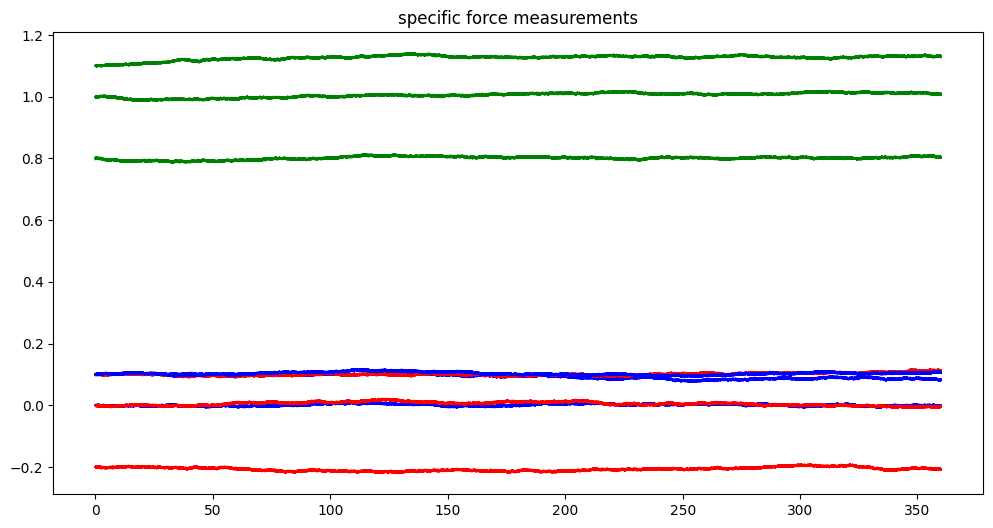

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(time, meas_hist[:,0], color='blue')
plt.plot(time, meas_hist[:,1], color='red')
plt.plot(time, meas_hist[:,2], color='green')
plt.plot(time, meas_hist[:,6], color='blue')
plt.plot(time, meas_hist[:,7], color='red')
plt.plot(time, meas_hist[:,8], color='green')
plt.plot(time, meas_hist[:,12], color='blue')
plt.plot(time, meas_hist[:,13], color='red')
plt.plot(time, meas_hist[:,14], color='green')
plt.title("specific force measurements")

Text(0.5, 1.0, 'angular rate measurements')

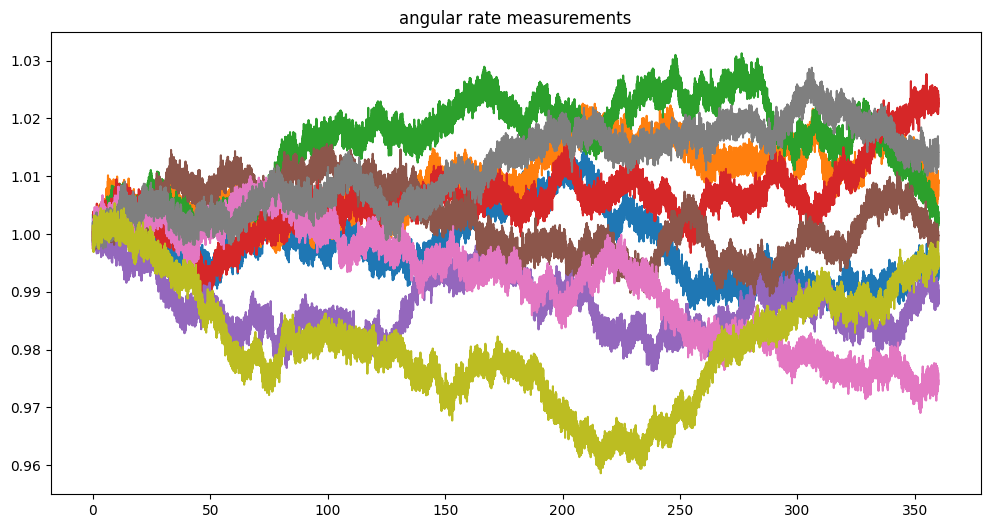

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(time, meas_hist[:,3])
plt.plot(time, meas_hist[:,4])
plt.plot(time, meas_hist[:,5])
plt.plot(time, meas_hist[:,9])
plt.plot(time, meas_hist[:,10])
plt.plot(time, meas_hist[:,11])
plt.plot(time, meas_hist[:,15])
plt.plot(time, meas_hist[:,16])
plt.plot(time, meas_hist[:,17])
plt.title("angular rate measurements")